# EVP-KLEE Performance Analysis Figures

This notebook generates publication-quality figures for the EVP-KLEE paper.

## Figures Generated:
1. **RQ1**: Parallel Coordinates Plot
2. **RQ1**: Improvement Heatmap
3. **RQ2**: Overhead vs Benefit Analysis
4. **RQ3**: Performance Variation Analysis


In [12]:
# Import required libraries
import sys
from pathlib import Path
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import warnings
warnings.filterwarnings('ignore')

# Add scripts directory to path
script_dir = Path('/home/roxana/VASE-klee/EVP-KLEE/scripts')
sys.path.insert(0, str(script_dir))

# Import data processing functions
from EVP_data_processor import (
    load_and_process_data,
    prepare_rq1_analysis,
    prepare_rq2_analysis,
    prepare_rq3_analysis
)


In [13]:
# Load and process data
print("Loading data from CSV files...")
df = load_and_process_data()

print(f"\nLoaded data for {df['Program'].nunique()} programs")
print(f"Total data points: {len(df)}")

# Prepare analysis dataframes
rq1_df = prepare_rq1_analysis(df)
rq2_df = prepare_rq2_analysis(df)
rq3_df = prepare_rq3_analysis(df)

print("\nData preparation complete!")
print(f"\nRQ1 data shape: {rq1_df.shape}")
print(f"RQ2 data shape: {rq2_df.shape}")
print(f"RQ3 data shape: {rq3_df.shape}")


Loading data from CSV files...
Processing /home/roxana/VASE-klee/EVP-KLEE/results/temp_results/coreutils-tmp/cp/cp-stats-evp.csv...
Processing /home/roxana/VASE-klee/EVP-KLEE/results/temp_results/coreutils-tmp/cp/cp-stats-vanilla.csv...
Processing /home/roxana/VASE-klee/EVP-KLEE/results/temp_results/coreutils-tmp/chmod/chmod-stats-evp.csv...
Processing /home/roxana/VASE-klee/EVP-KLEE/results/temp_results/coreutils-tmp/chmod/chmod-stats-vanilla.csv...
Processing /home/roxana/VASE-klee/EVP-KLEE/results/temp_results/coreutils-tmp/mv/mv-stats-evp.csv...
Processing /home/roxana/VASE-klee/EVP-KLEE/results/temp_results/coreutils-tmp/mv/mv-stats-vanilla.csv...
Processing /home/roxana/VASE-klee/EVP-KLEE/results/temp_results/coreutils-tmp/du/du-stats-evp.csv...
Processing /home/roxana/VASE-klee/EVP-KLEE/results/temp_results/coreutils-tmp/du/du-stats-vanilla.csv...
Processing /home/roxana/VASE-klee/EVP-KLEE/results/temp_results/coreutils-tmp/ln/ln-stats-evp.csv...
Processing /home/roxana/VASE-kle

## Figure 1: RQ1 - Parallel Coordinates Plot


Figure 1 saved: rq1-parallel-coordinates-new.pdf and .png


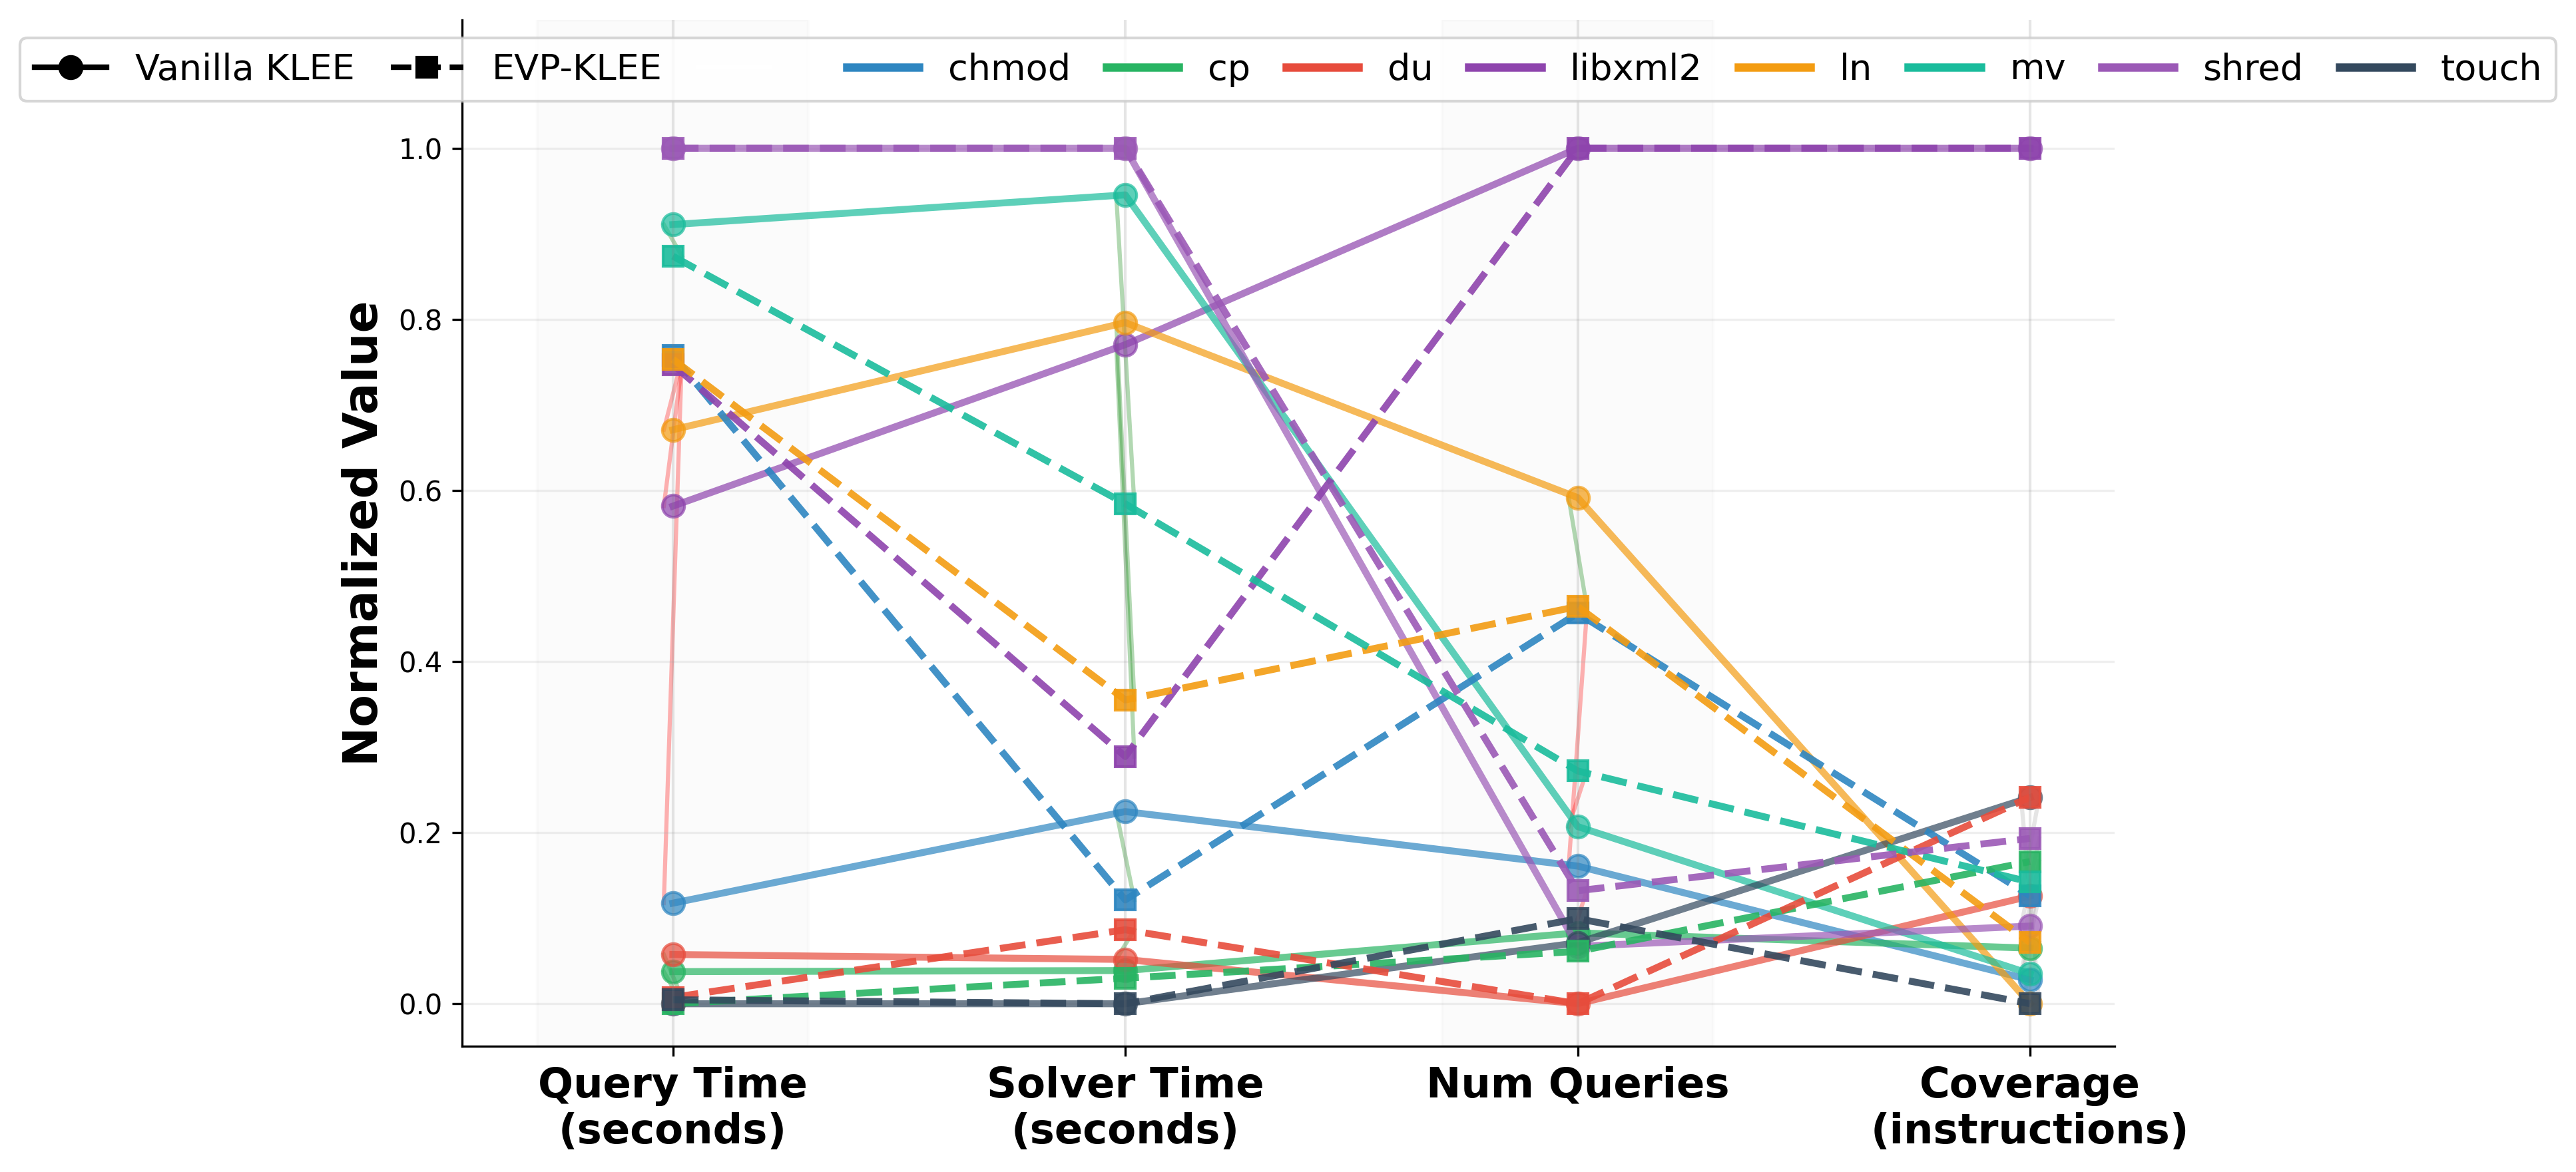

In [14]:
# Set publication quality parameters
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']
plt.rcParams['font.size'] = 11
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 13
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['pdf.fonttype'] = 42

# Extract raw data for both Vanilla and EVP
programs = sorted(df['Program'].unique())

# Prepare data arrays
vanilla_query = []
evp_query = []
vanilla_solver = []
evp_solver = []
vanilla_queries = []
evp_queries = []
coverage_vanilla = []
coverage_evp = []
valid_programs = []

for program in programs:
    program_data = df[df['Program'] == program]
    vanilla_data = program_data[program_data['Variant'] == 'vanilla']
    evp_data = program_data[program_data['Variant'] == 'evp']
    
    if not vanilla_data.empty and not evp_data.empty:
        vanilla_row = vanilla_data.iloc[0]
        evp_row = evp_data.iloc[0]
        
        # Query Time (convert from ms to seconds)
        vanilla_query.append(vanilla_row['FinalQueryTime'] / 1000)
        evp_query.append(evp_row['FinalQueryTime'] / 1000)
        
        # Solver Time (convert from ms to seconds)
        vanilla_solver.append(vanilla_row['FinalSolverTime'] / 1000)
        evp_solver.append(evp_row['FinalSolverTime'] / 1000)
        
        # Num Queries
        vanilla_queries.append(vanilla_row['TotalQueries'])
        evp_queries.append(evp_row['TotalQueries'])
        
        # Coverage
        coverage_vanilla.append(vanilla_row['FinalCoverage'])
        coverage_evp.append(evp_row['FinalCoverage'])
        
        valid_programs.append(program)

# Convert to numpy arrays
vanilla_query = np.array(vanilla_query)
evp_query = np.array(evp_query)
vanilla_solver = np.array(vanilla_solver)
evp_solver = np.array(evp_solver)
vanilla_queries = np.array(vanilla_queries)
evp_queries = np.array(evp_queries)
coverage_vanilla = np.array(coverage_vanilla)
coverage_evp = np.array(coverage_evp)

if len(valid_programs) > 0:
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Normalize data for parallel coordinates (0-1 scale)
    def normalize(data):
        return (data - data.min()) / (data.max() - data.min()) if data.max() != data.min() else data
    
    # Prepare data for parallel coordinates
    x_labels = ['Query Time\n(seconds)', 'Solver Time\n(seconds)', 'Num Queries', 'Coverage\n(instructions)']
    x_positions = np.array([0, 1, 2, 3])
    
    # Colors for each program (professional palette)
    # Use a color cycle that works for any number of programs
    color_cycle = ['#2E86C1', '#28B463', '#E74C3C', '#8E44AD', '#F39C12', '#1ABC9C', '#9B59B6', '#34495E']
    colors = {prog: color_cycle[i % len(color_cycle)] for i, prog in enumerate(valid_programs)}
    
    # Plot lines for Vanilla KLEE (solid lines)
    for i, prog in enumerate(valid_programs):
        # Normalize values
        norm_query = normalize(vanilla_query)[i]
        norm_solver = normalize(vanilla_solver)[i]
        norm_queries = normalize(vanilla_queries)[i]
        norm_coverage = normalize(coverage_vanilla)[i]
        y_vanilla = [norm_query, norm_solver, norm_queries, norm_coverage]
        
        # Plot vanilla line
        ax.plot(x_positions, y_vanilla, 'o-',
                color=colors[prog], linewidth=2.5, markersize=8,
                alpha=0.7, label=f'{prog} (Vanilla)')
    
    # Plot lines for EVP KLEE (dashed lines)
    for i, prog in enumerate(valid_programs):
        # Normalize values
        norm_query = normalize(evp_query)[i]
        norm_solver = normalize(evp_solver)[i]
        norm_queries = normalize(evp_queries)[i]
        norm_coverage = normalize(coverage_evp)[i]
        y_evp = [norm_query, norm_solver, norm_queries, norm_coverage]
        
        # Plot EVP line
        ax.plot(x_positions, y_evp, 's--',
                color=colors[prog], linewidth=2.5, markersize=7,
                alpha=0.9, label=f'{prog} (EVP)')
        
        # Connect vanilla to EVP with a thin gray line for the same program
        y_vanilla = [normalize(vanilla_query)[i], normalize(vanilla_solver)[i],
                     normalize(vanilla_queries)[i], normalize(coverage_vanilla)[i]]
        for j in range(len(x_positions)):
            # Color code the connection based on improvement
            if j == 1:  # Solver time (where EVP generally improves)
                conn_color = 'green'
                conn_alpha = 0.3
            elif j in [0, 2]:  # Query time and num queries (where EVP often performs worse)
                conn_color = 'red' if y_evp[j] > y_vanilla[j] else 'green'
                conn_alpha = 0.3
            else:
                conn_color = 'gray'
                conn_alpha = 0.2
            
            ax.plot([x_positions[j]-0.02, x_positions[j]+0.02],
                    [y_vanilla[j], y_evp[j]],
                    color=conn_color, linewidth=1.5, alpha=conn_alpha, zorder=0)
    
    # Styling
    ax.set_xticks(x_positions)
    ax.set_xticklabels(x_labels, fontweight='bold')
    ax.set_ylim(-0.05, 1.15)
    ax.set_ylabel('Normalized Value', fontweight='bold', fontsize=17)
    
    # Add grid
    for x in x_positions:
        ax.axvline(x, color='gray', alpha=0.2, linestyle='-', linewidth=1)
    ax.grid(True, axis='y', alpha=0.2)
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Add background shading for each metric
    for i, x in enumerate(x_positions):
        if i % 2 == 0:
            ax.axvspan(x-0.3, x+0.3, alpha=0.03, color='gray', zorder=-1)
    
    # Create legend
    legend_elements = [
        Line2D([0], [0], color='black', linestyle='-', marker='o',
               markersize=8, label='Vanilla KLEE', linewidth=2),
        Line2D([0], [0], color='black', linestyle='--', marker='s',
               markersize=7, label='EVP-KLEE', linewidth=2),
        Line2D([0], [0], color='white', linestyle='-', marker='o',
               markersize=0, label=' '),  # Spacer
    ]
    
    # Add program color indicators to legend
    for prog in valid_programs:
        legend_elements.append(
            Line2D([0], [0], color=colors[prog], linestyle='-',
                   linewidth=3, label=prog)
        )
    
    ax.legend(handles=legend_elements, loc='upper center',
             bbox_to_anchor=(0.5, 1.00),
             frameon=True, fancybox=True, shadow=False,
             ncol=len(valid_programs) + 3, columnspacing=1, handlelength=2)
    
    plt.tight_layout()
    
    # Save figure
    plt.savefig('rq1-parallel-coordinates-new.pdf', dpi=300, bbox_inches='tight')
    plt.savefig('rq1-parallel-coordinates-new.png', dpi=300, bbox_inches='tight')
    print("Figure 1 saved: rq1-parallel-coordinates-new.pdf and .png")
    plt.show()
else:
    print("Warning: No data available for parallel coordinates plot")


Figure 1 saved: rq1-parallel-coordinates-new.pdf and .png


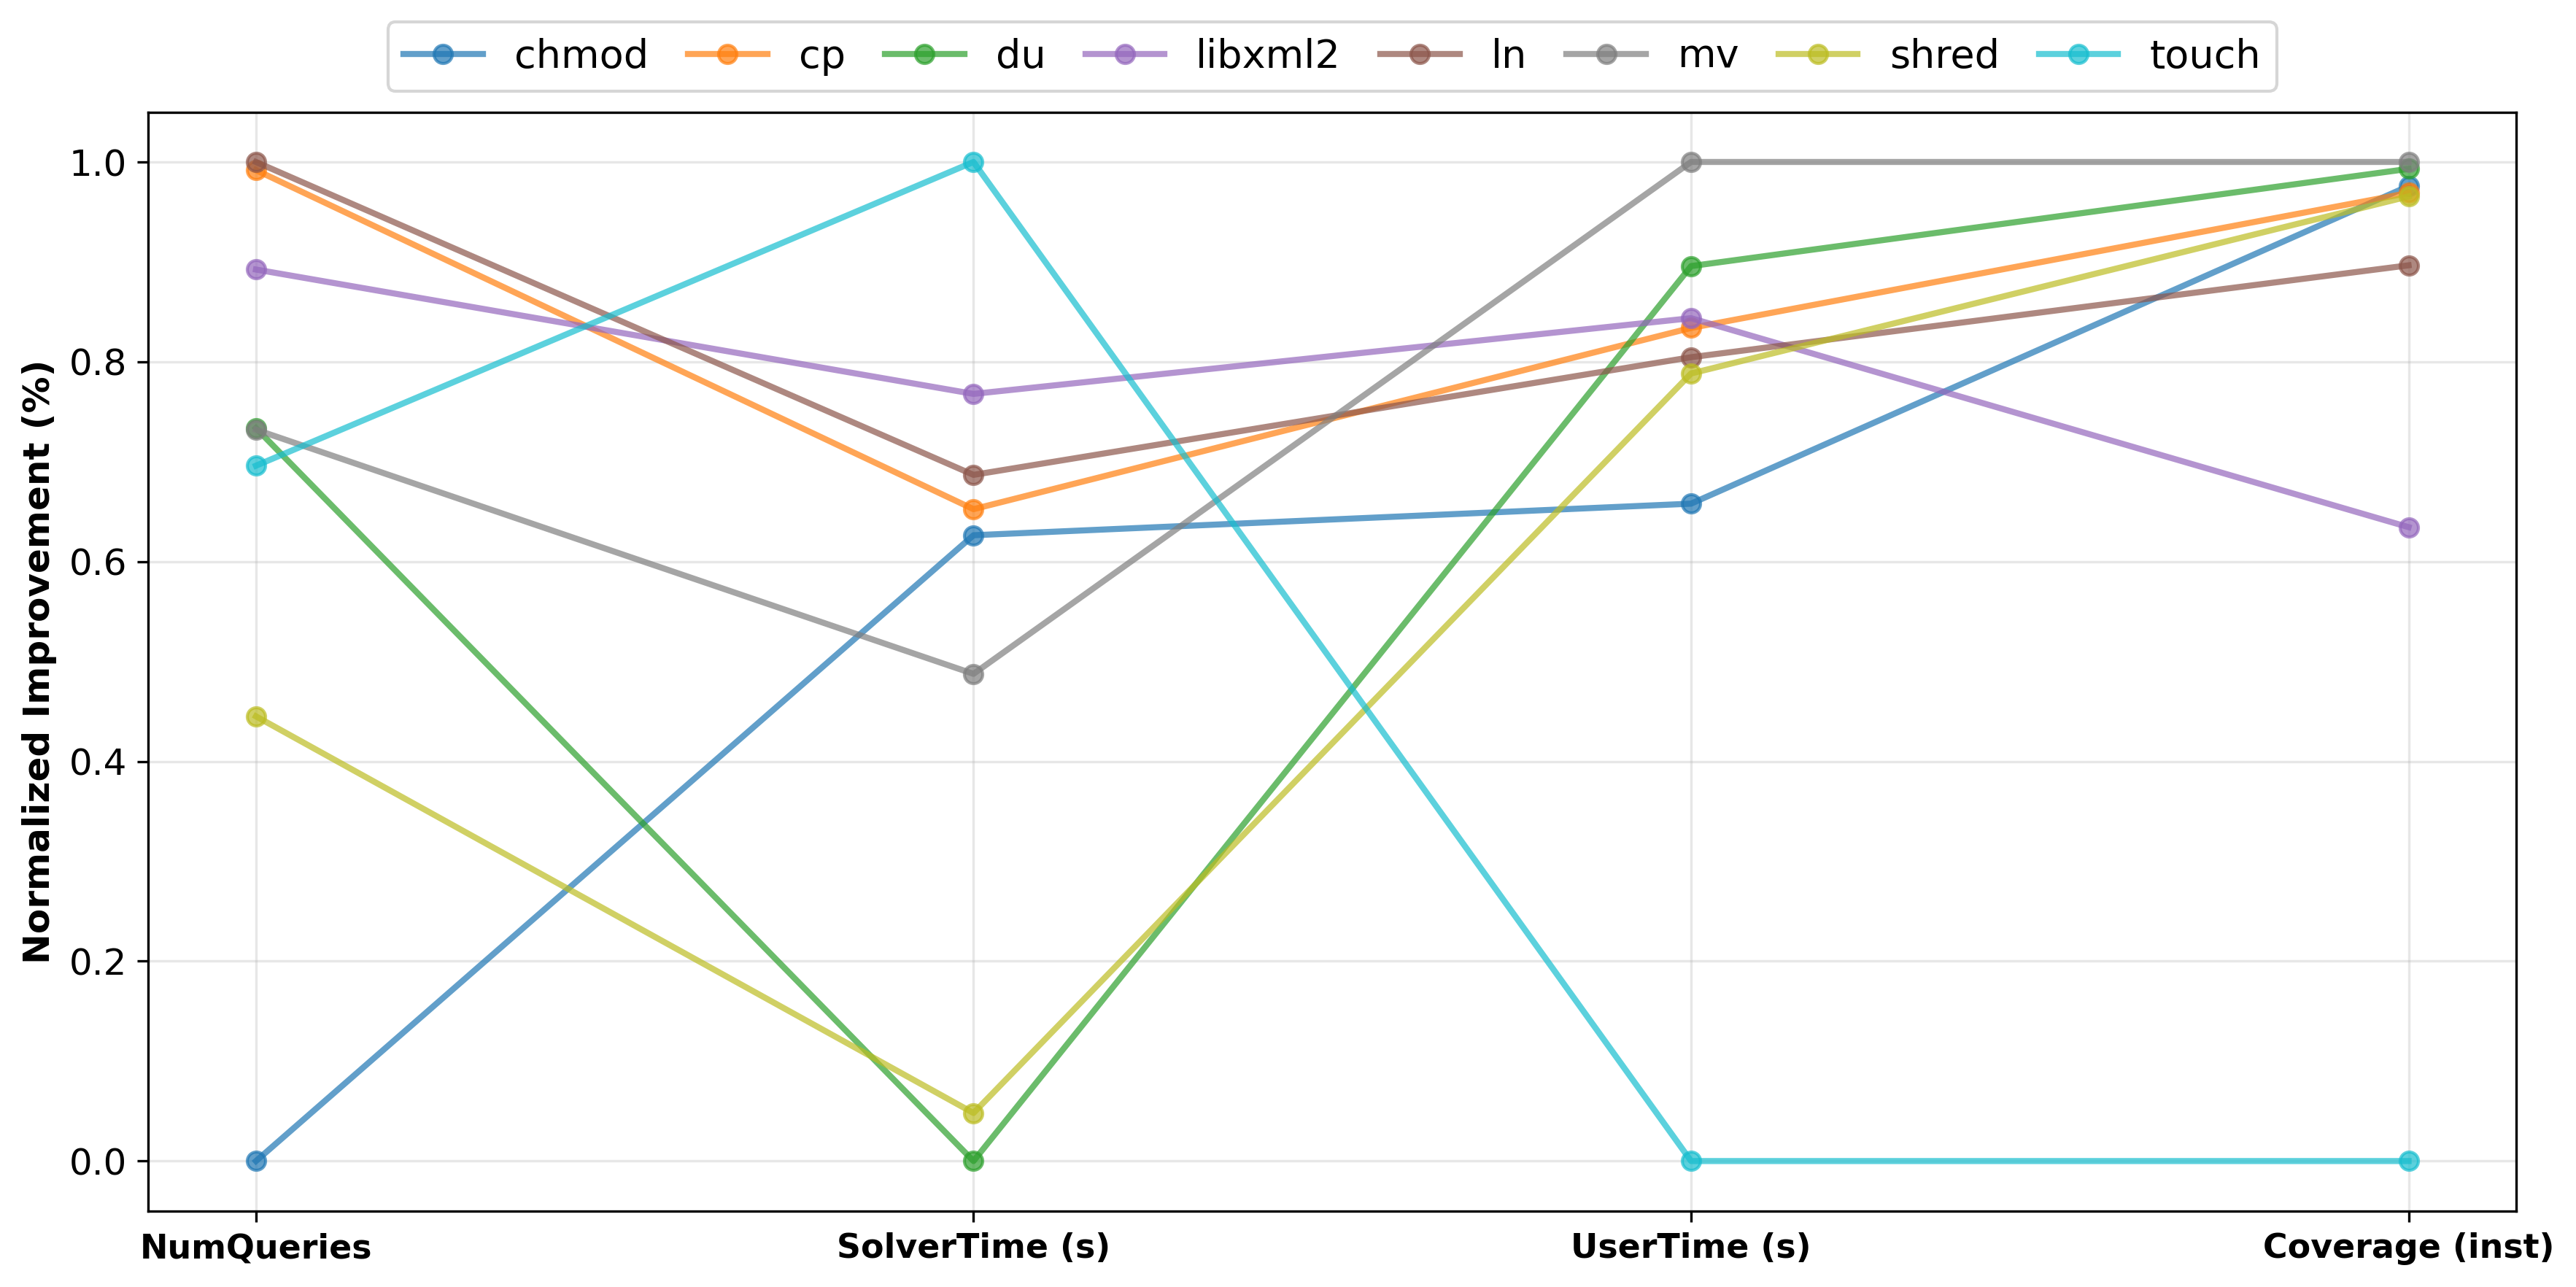

In [15]:
# Set up matplotlib parameters for publication quality
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

# Prepare data for parallel coordinates
programs = sorted(df['Program'].unique())
# metrics = ['QueryTime (s)', 'SolverTime (s)', 'UserTime (s)', 'Coverage (inst)']  # QueryTime COMMENTED OUT
metrics = ['NumQueries', 'SolverTime (s)', 'UserTime (s)', 'Coverage (inst)']

# Create parallel coordinates data
parallel_data = []
for program in programs:
    program_data = rq1_df[rq1_df['Program'] == program]
    if len(program_data) >= 4:  # Need all 4 metrics
        row = {'Program': program}
        for metric in metrics:
            metric_data = program_data[program_data['Metric'] == metric]
            if not metric_data.empty:
                row[metric] = metric_data.iloc[0]['Improvement (%)']
            else:
                row[metric] = 0
        parallel_data.append(row)

parallel_df = pd.DataFrame(parallel_data)

if not parallel_df.empty:
    # Create parallel coordinates plot
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Normalize data for parallel coordinates
    normalized_data = parallel_df[metrics].copy()
    for col in metrics:
        col_min = normalized_data[col].min()
        col_max = normalized_data[col].max()
        if col_max > col_min:
            normalized_data[col] = (normalized_data[col] - col_min) / (col_max - col_min)
        else:
            normalized_data[col] = 0.5
    
    # Plot lines for each program
    colors = plt.cm.tab10(np.linspace(0, 1, len(parallel_df)))
    for idx, (_, row) in enumerate(parallel_df.iterrows()):
        values = [normalized_data.loc[idx, metric] for metric in metrics]
        ax.plot(range(len(metrics)), values, marker='o', linewidth=2, 
                label=row['Program'], color=colors[idx], alpha=0.7)
    
    ax.set_xticks(range(len(metrics)))
    ax.set_xticklabels(metrics, fontsize=11, fontweight='bold')
    ax.set_ylabel('Normalized Improvement (%)', fontsize=12, fontweight='bold')
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.10),
              ncol=len(parallel_df), frameon=True, fancybox=True, shadow=False,
              columnspacing=1, handlelength=2, fontsize=13)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('rq1-parallel-coordinates-new.pdf', dpi=300, bbox_inches='tight')
    plt.savefig('rq1-parallel-coordinates-new.png', dpi=300, bbox_inches='tight')
    print("Figure 1 saved: rq1-parallel-coordinates-new.pdf and .png")
    plt.show()
else:
    print("Warning: No data available for parallel coordinates plot")

## Figure 2: RQ1 - Improvement Heatmap


Figure 2 saved: rq1-improvement-heatmap-new.pdf and .png


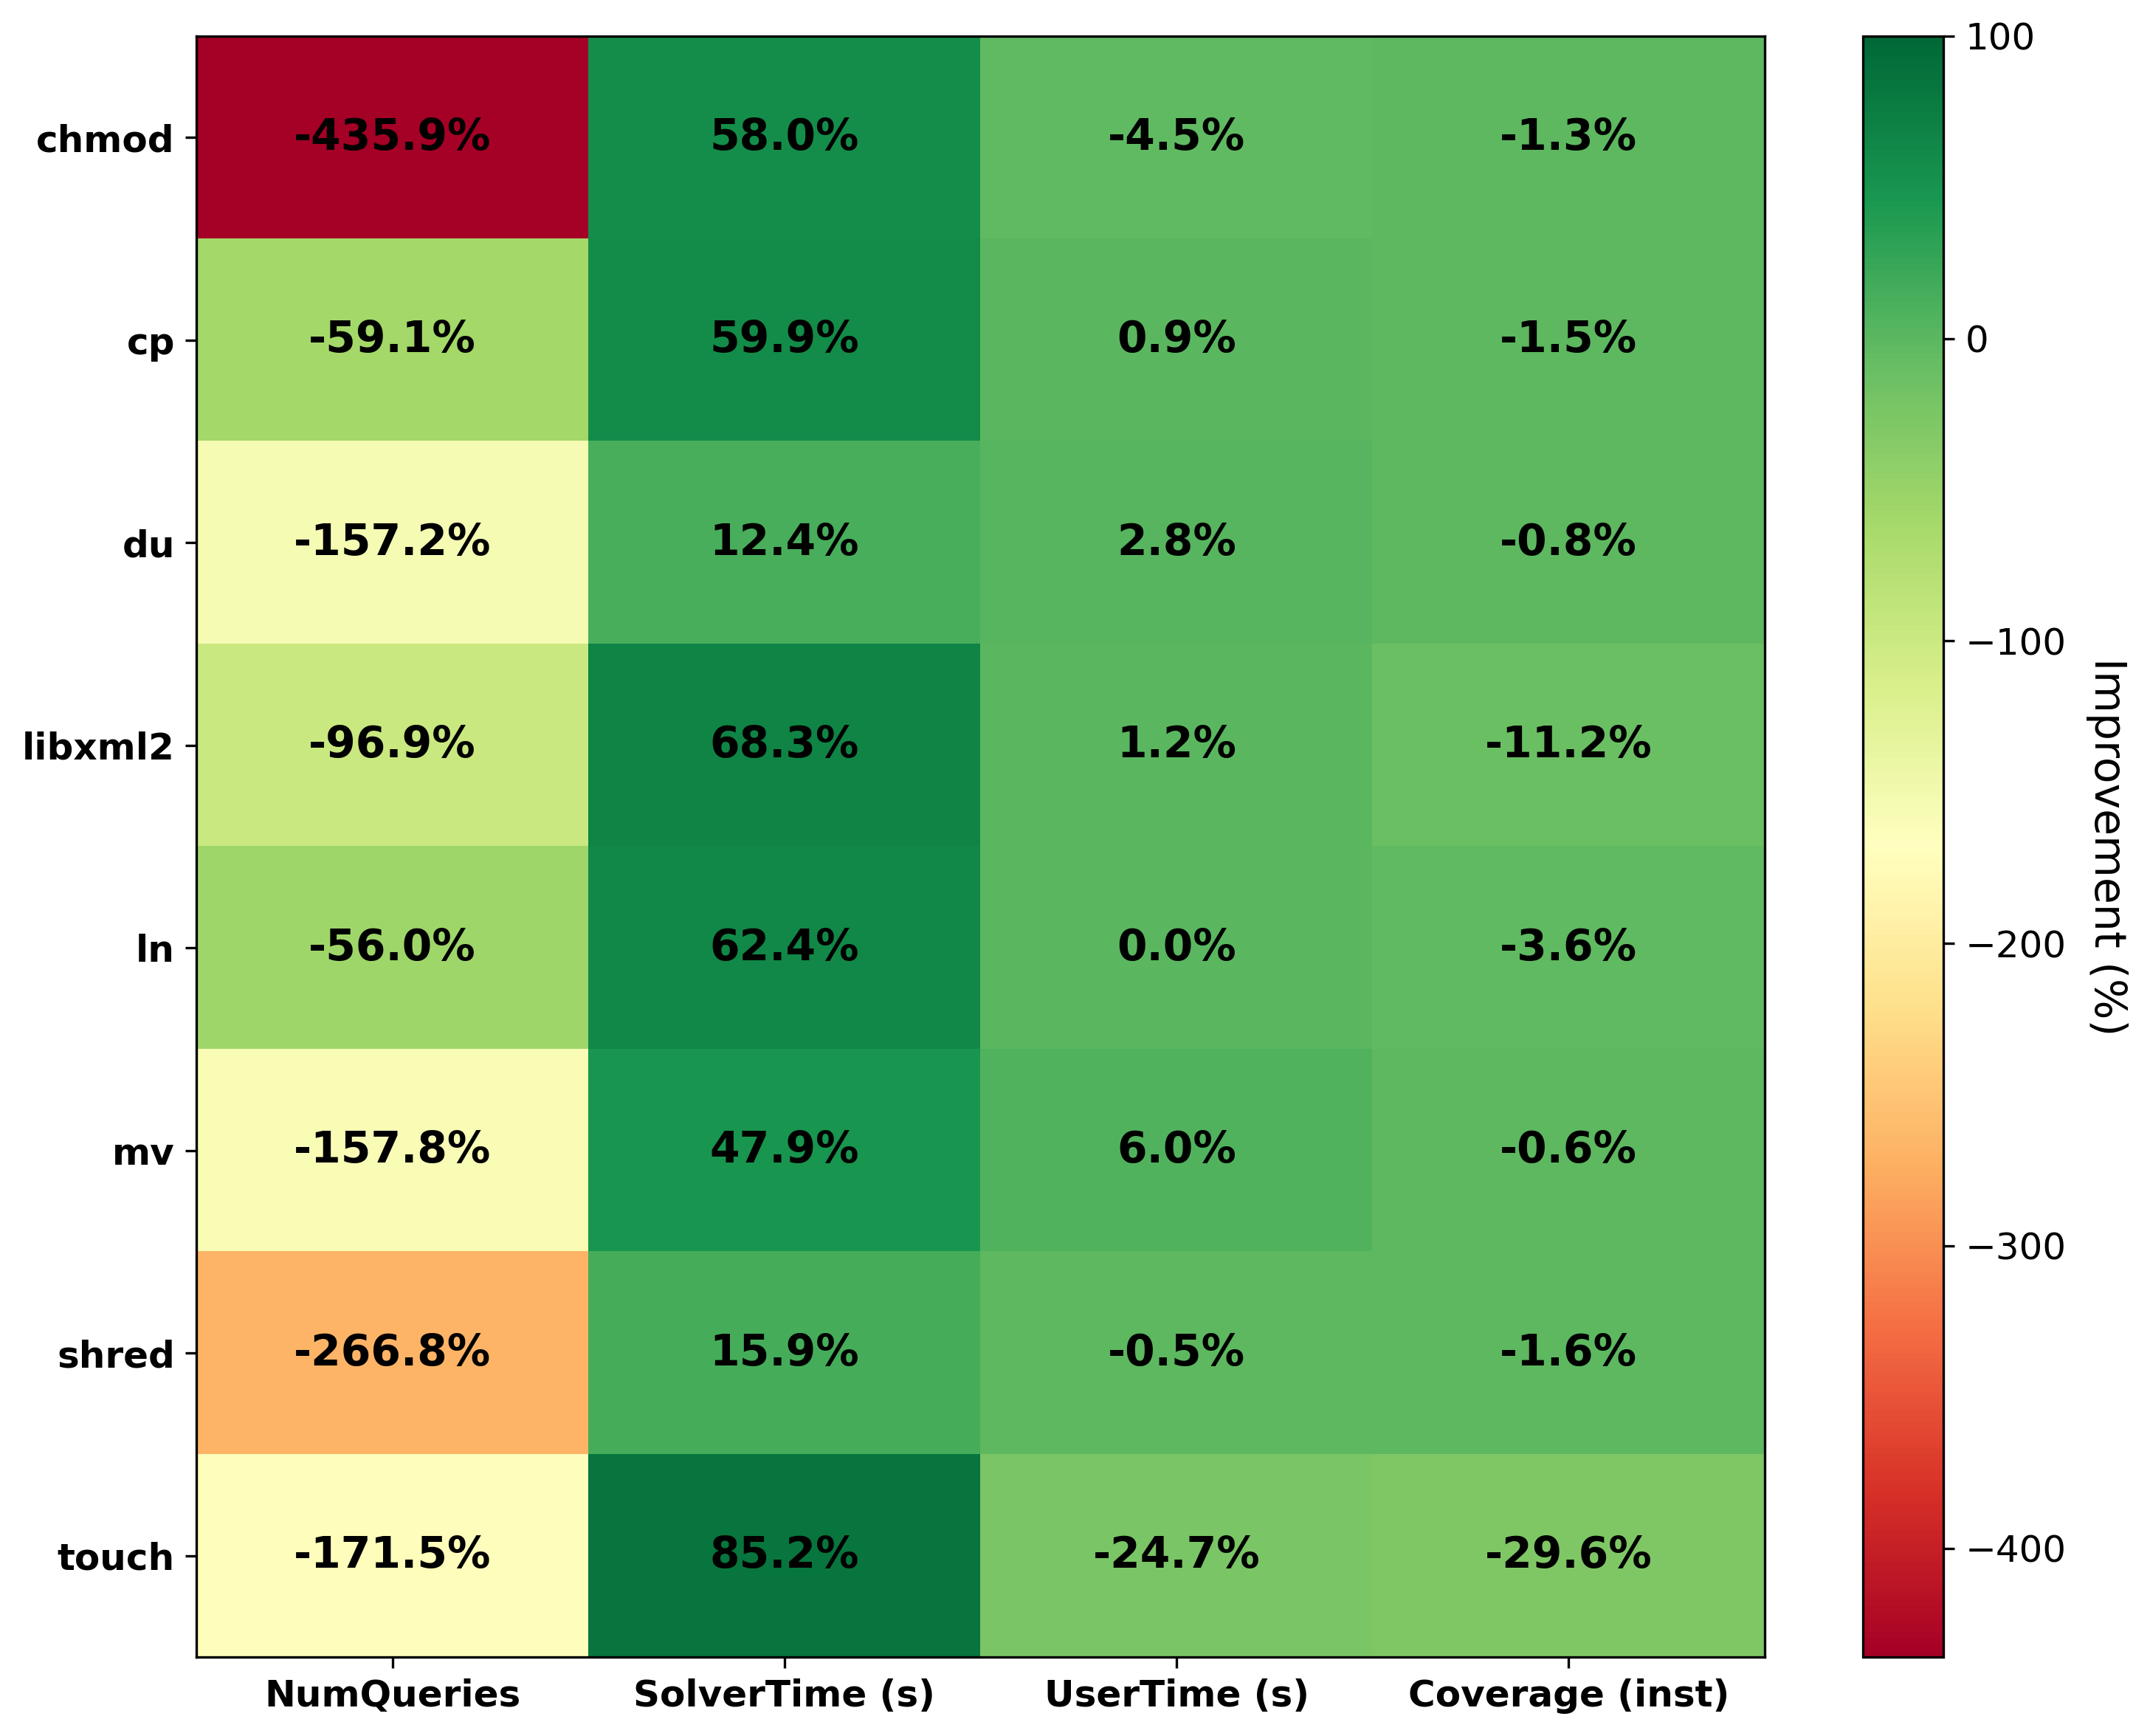

In [16]:
# Create heatmap data
# Ensure inputs are defined in this cell
programs = sorted(df['Program'].unique())
metrics = ['NumQueries', 'SolverTime (s)', 'UserTime (s)', 'Coverage (inst)']

heatmap_data = []
for program in programs:
    program_data = rq1_df[rq1_df['Program'] == program]
    row = {'Program': program}
    for metric in metrics:
        metric_data = program_data[program_data['Metric'] == metric]
        if not metric_data.empty:
            row[metric] = metric_data.iloc[0]['Improvement (%)']
        else:
            row[metric] = 0
    heatmap_data.append(row)

heatmap_df = pd.DataFrame(heatmap_data).set_index('Program')

if not heatmap_df.empty:
    # Create heatmap
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Determine vmin and vmax for better visualization
    all_values = heatmap_df.values.flatten()
    vmin = min(all_values.min(), -50)
    vmax = max(all_values.max(), 100)
    
    im = ax.imshow(heatmap_df.values, cmap='RdYlGn', aspect='auto', vmin=vmin, vmax=vmax)
    
    # Set axis labels
    #ax.set_title('RQ1: Improvement Heatmap', fontsize=14, fontweight='bold')
    
    # Set ticks and labels
    ax.set_xticks(np.arange(len(metrics)))
    ax.set_yticks(np.arange(len(programs)))
    ax.set_xticklabels(metrics, fontsize=12, fontweight='bold')
    ax.set_yticklabels(heatmap_df.index, fontsize=12, fontweight='bold')
    
    # Add text annotations
    for i in range(len(programs)):
        for j in range(len(metrics)):
            text = ax.text(j, i, f"{heatmap_df.iloc[i, j]:.1f}%",
                          ha="center", va="center", color="black", fontsize=14, fontweight="bold")
    
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Improvement (%)', rotation=270, labelpad=20)
    
    plt.tight_layout()
    plt.savefig('rq1-improvement-heatmap-new.pdf', dpi=300, bbox_inches='tight')
    plt.savefig('rq1-improvement-heatmap-new.png', dpi=300, bbox_inches='tight')
    print("Figure 2 saved: rq1-improvement-heatmap-new.pdf and .png")
    plt.show()
else:
    print("Warning: No data available for heatmap")


## Figure 3: RQ2 - Overhead vs Benefit Analysis


Figure 3 saved: rq2-overhead-benefit-new.pdf and .png


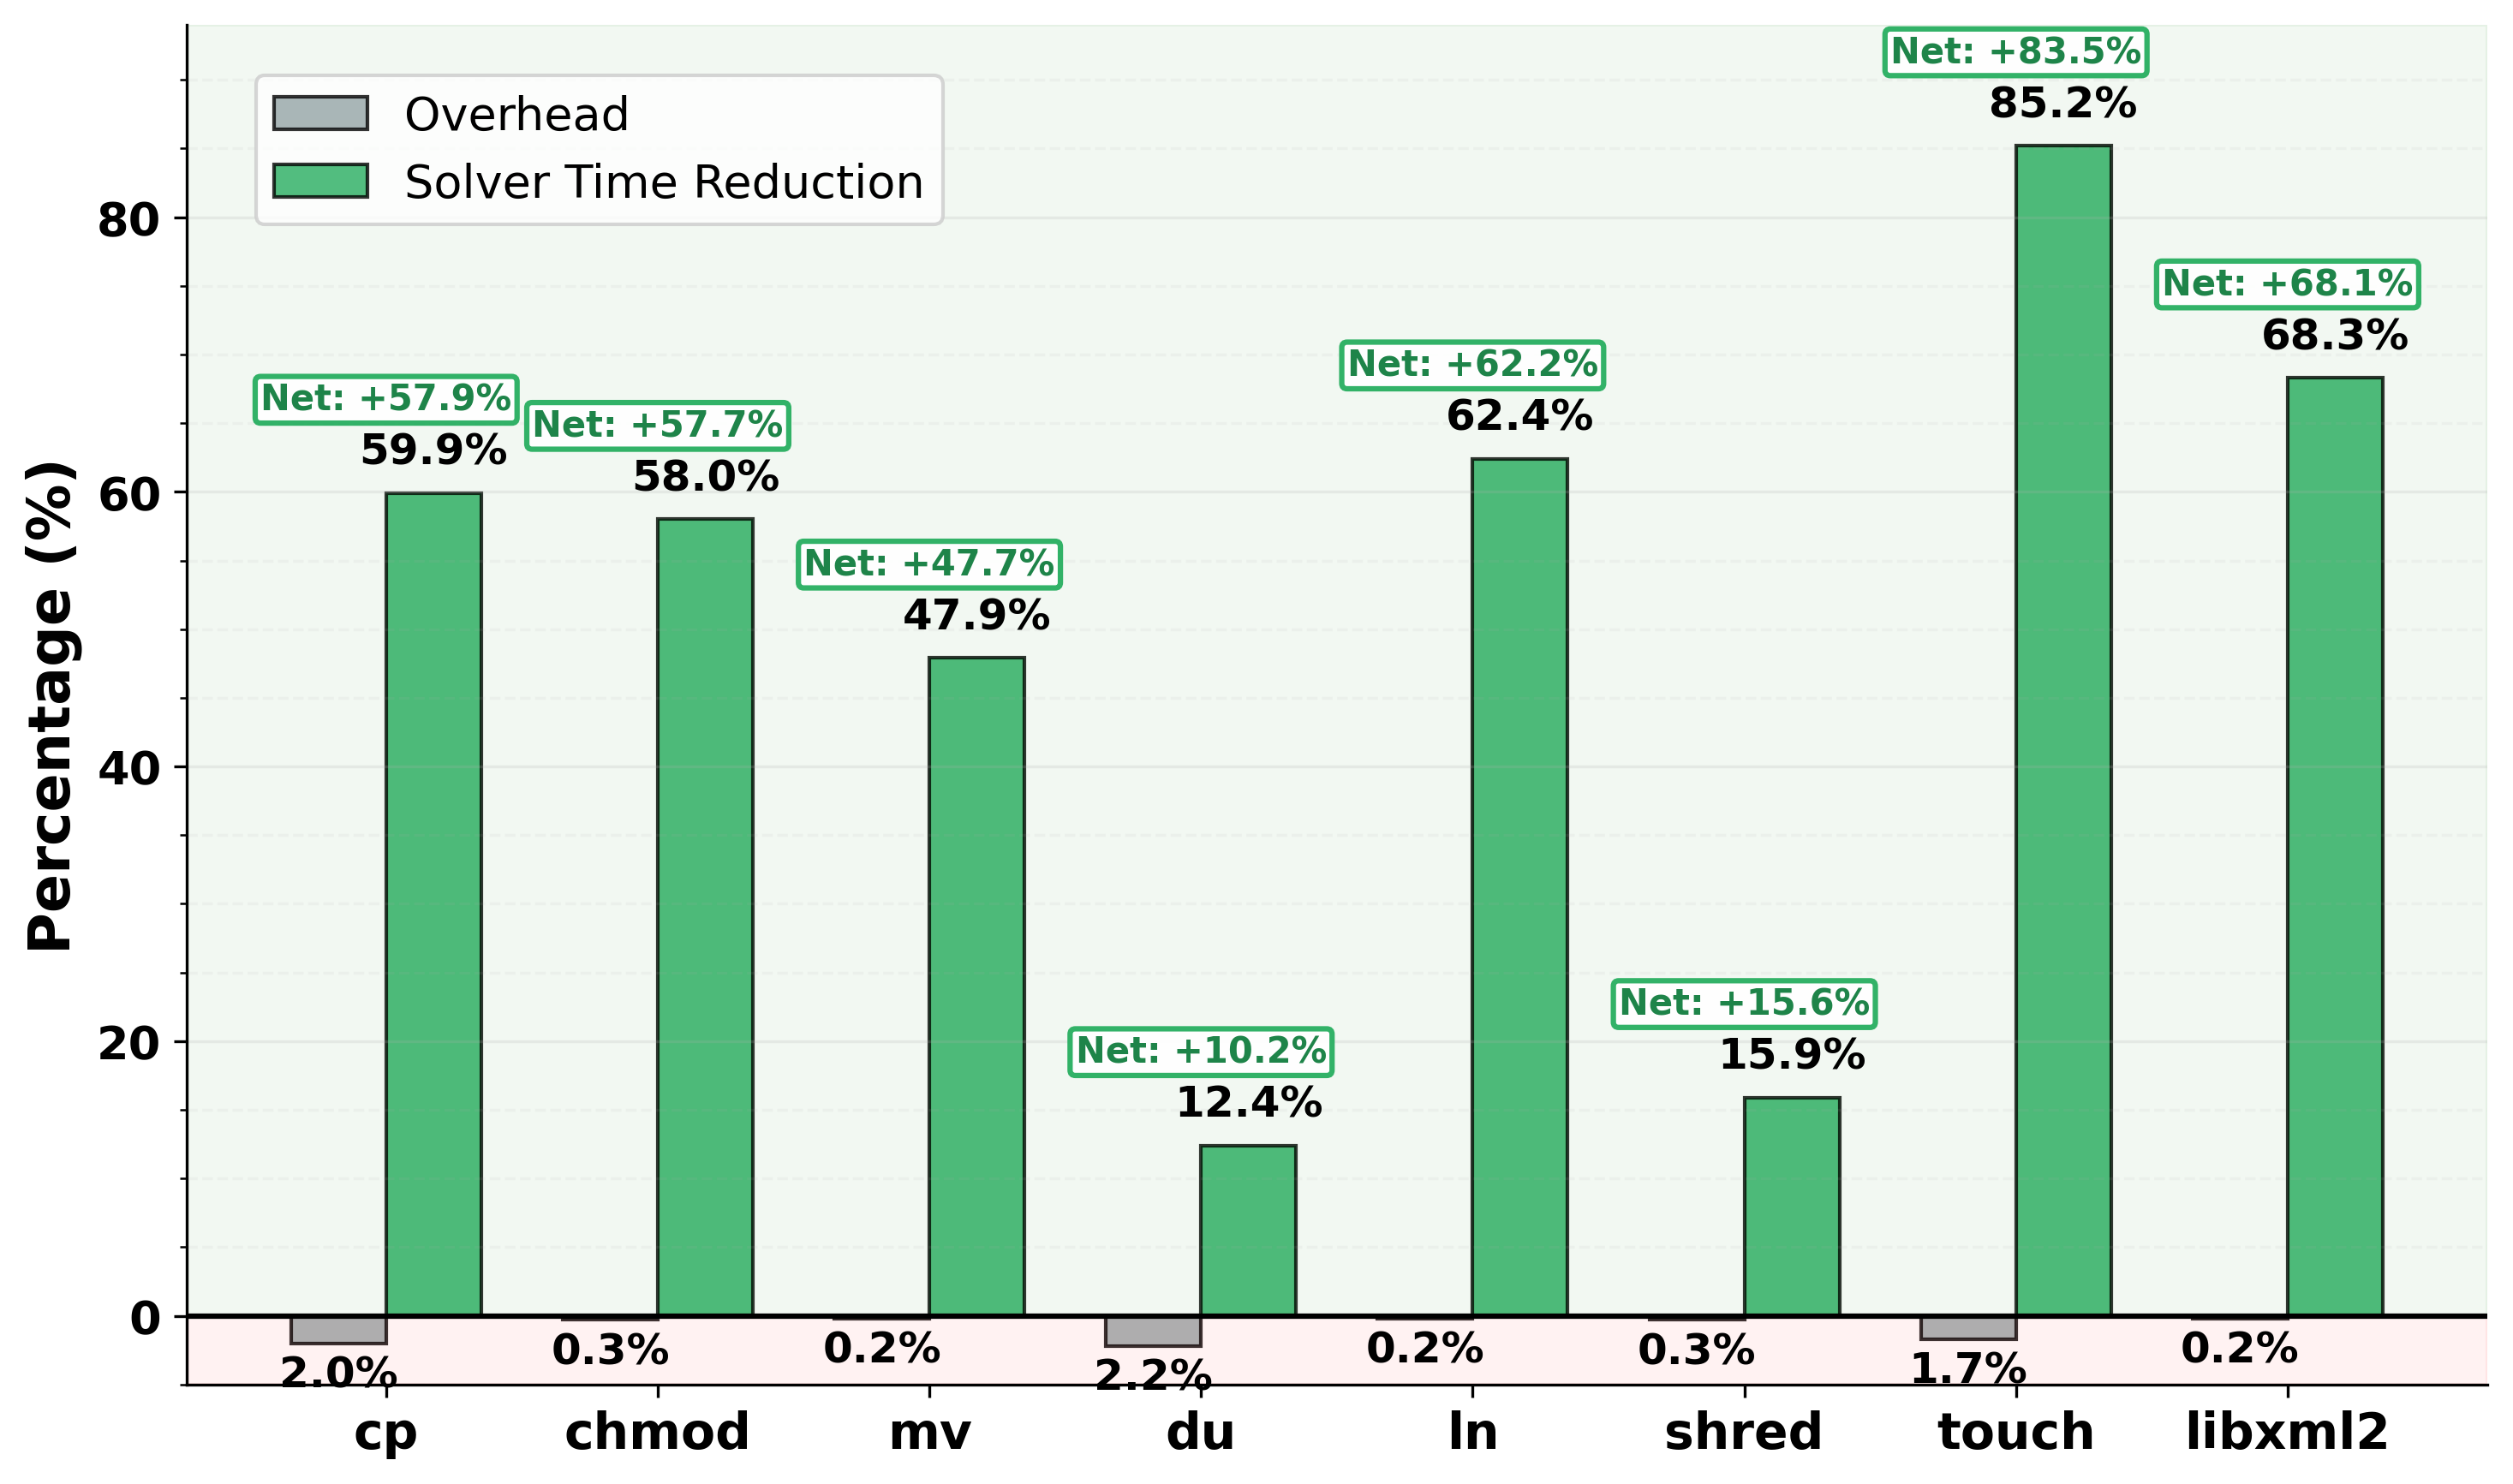


RQ2: OVERHEAD ANALYSIS SUMMARY

=== Overhead Breakdown ===
cp      :   2.0% overhead
chmod   :   0.3% overhead
mv      :   0.2% overhead
du      :   2.2% overhead
ln      :   0.2% overhead
shred   :   0.3% overhead
touch   :   1.7% overhead
libxml2 :   0.2% overhead

=== Solver Performance Gains ===
cp      :  59.9% improvement
chmod   :  58.0% improvement
mv      :  47.9% improvement
du      :  12.4% improvement
ln      :  62.4% improvement
shred   :  15.9% improvement
touch   :  85.2% improvement
libxml2 :  68.3% improvement

=== Net Benefits (Solver Improvement - Overhead) ===
cp      : + 57.9% net benefit
chmod   : + 57.7% net benefit
mv      : + 47.7% net benefit
du      : + 10.2% net benefit
ln      : + 62.2% net benefit
shred   : + 15.6% net benefit
touch   : + 83.5% net benefit
libxml2 : + 68.1% net benefit

=== Overall Statistics ===
Average Overhead: 0.89%
Min Overhead: 0.20% (mv)
Max Overhead: 2.20% (du)
Average Solver Improvement: 51.2%
Average Net Benefit: 50.4%
All progr

In [17]:
# Set publication quality parameters with INCREASED FONT SIZES
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']
plt.rcParams['font.size'] = 14
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 17
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['pdf.fonttype'] = 42

# Prepare RQ2 data - Get solver time improvements from RQ1
solver_improvements = {}
for program in programs:
    program_data = rq1_df[(rq1_df['Program'] == program) & 
                          (rq1_df['Metric'] == 'SolverTime (s)')]
    if not program_data.empty:
        solver_improvements[program] = program_data.iloc[0]['Improvement (%)']
    else:
        solver_improvements[program] = 0

# Merge with RQ2 overhead data
overhead_benefit_data = []
for _, row in rq2_df.iterrows():
    program = row['Program']
    overhead = row['Overhead (%)']
    benefit = solver_improvements.get(program, 0)
    overhead_benefit_data.append({
        'Program': program,
        'Overhead (%)': overhead,
        'Benefit (%)': benefit,
        'Net Benefit (%)': benefit - overhead
    })

ob_df = pd.DataFrame(overhead_benefit_data)

if not ob_df.empty:
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Colors (professional palette)
    colors = {
        'overhead': '#95A5A6',    # Gray
        'improvement': '#27AE60'   # Green
    }
    
    # Create grouped bar chart
    x = np.arange(len(ob_df))
    width = 0.35
    
    # Plot overhead (negative) and improvement (positive)
    bars1 = ax.bar(x - width/2, -ob_df['Overhead (%)'], width,
                    label='Overhead', color=colors['overhead'],
                    edgecolor='black', linewidth=1, alpha=0.8)
    bars2 = ax.bar(x + width/2, ob_df['Benefit (%)'], width,
                    label='Solver Time Reduction', color=colors['improvement'],
                    edgecolor='black', linewidth=1, alpha=0.8)
    
    # Add value labels with LARGER FONTS
    for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
        # Overhead label - positioned below the bar
        overhead_val = ob_df.iloc[i]['Overhead (%)']
        ax.text(bar1.get_x() + bar1.get_width()/2,
                -overhead_val - 0.8,
                f'{overhead_val:.1f}%',
                ha='center', va='top', fontweight='bold', fontsize=12)
        
        # Improvement label - positioned above the bar
        benefit_val = ob_df.iloc[i]['Benefit (%)']
        ax.text(bar2.get_x() + bar2.get_width()/2,
                benefit_val + 1.5,
                f'{benefit_val:.1f}%',
                ha='center', va='bottom', fontweight='bold', fontsize=12)
        
        # Net benefit annotation - positioned directly above each benefit bar
        # This creates natural spacing and clear association with each program
        net_benefit = ob_df.iloc[i]['Net Benefit (%)']
        
        # Position net benefit label above the benefit bar with consistent offset
        # This ensures each box is clearly associated with its program and naturally spaced
        y_pos = benefit_val + 6.8  # Position above each benefit bar with consistent spacing
        
        # Use smaller, more compact boxes with better contrast
        # White background with dark green text for better readability
        ax.text(x[i], y_pos, f'Net: +{net_benefit:.1f}%',
                ha='center', va='center',
                bbox=dict(boxstyle='round,pad=0.15', facecolor='white',
                         edgecolor='#27AE60', alpha=0.95, linewidth=1.5),
                fontsize=10, fontweight='bold', color='#1E8449')  # Darker green for better contrast
    
    # Styling with LARGER Y-AXIS LABELS
    ax.set_ylabel('Percentage (%)', fontweight='bold', fontsize=16)
    ax.set_xticks(x)
    ax.set_xticklabels(ob_df['Program'], fontweight='bold', fontsize=14)
    ax.axhline(y=0, color='black', linestyle='-', linewidth=1.5)
    
    # Set y-axis limits dynamically based on data
    max_val = max(ob_df['Benefit (%)'].max(), abs(ob_df['Overhead (%)'].max()))
    # Add space for bar labels and net benefit boxes (positioned above benefit bars)
    # Net boxes are at benefit_val + 4.5, so we need extra space for the tallest one
    max_net_height = ob_df['Benefit (%)'].max() + 6.8 + 2  # Add 2 for padding
    y_max = max(max_val + 8, max_net_height)  # Space for bar labels and net boxes
    y_min = -max(5, abs(ob_df['Overhead (%)'].min()) + 2)  # Space for overhead labels below
    ax.set_ylim(y_min, y_max)
    
    # MAKE Y-AXIS TICK LABELS BOLD AND LARGER
    # Create y-ticks dynamically
    y_ticks_major = np.arange(0, y_max, 20 if y_max > 40 else 10)
    if y_ticks_major[-1] < y_max:
        y_ticks_major = np.append(y_ticks_major, y_ticks_major[-1] + (20 if y_max > 40 else 10))
    y_ticks_major = y_ticks_major[y_ticks_major <= y_max]
    ax.set_yticks(y_ticks_major)
    y_labels = [f'{int(y)}' for y in y_ticks_major]
    ax.set_yticklabels(y_labels, fontweight='bold', fontsize=13)
    
    # Add minor gridlines
    ax.set_yticks(np.arange(y_min, y_max, 5), minor=True)
    ax.grid(True, axis='y', alpha=0.2, linestyle='-', which='major')
    ax.grid(True, axis='y', alpha=0.1, linestyle='--', which='minor')
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Add shaded regions (subtle)
    ax.axhspan(y_min, 0, alpha=0.05, color='red', label='_nolegend_')
    ax.axhspan(0, y_max, alpha=0.05, color='green', label='_nolegend_')
    
    # Move legend to upper left since values are high on the right
    ax.legend(loc='upper left', bbox_to_anchor=(0.02, 0.98),
              frameon=True, fancybox=True, shadow=False, ncol=1,
              fontsize=13)
    
    plt.tight_layout()
    
    # Save figures
    plt.savefig('rq2-overhead-benefit-new.pdf', dpi=300, bbox_inches='tight')
    plt.savefig('rq2-overhead-benefit-new.png', dpi=300, bbox_inches='tight')
    print("Figure 3 saved: rq2-overhead-benefit-new.pdf and .png")
    plt.show()
    
    # Print detailed summary statistics
    print("\n" + "="*60)
    print("RQ2: OVERHEAD ANALYSIS SUMMARY")
    print("="*60)
    print("\n=== Overhead Breakdown ===")
    for i, row in ob_df.iterrows():
        print(f"{row['Program']:8}: {row['Overhead (%)']:5.1f}% overhead")
    print("\n=== Solver Performance Gains ===")
    for i, row in ob_df.iterrows():
        print(f"{row['Program']:8}: {row['Benefit (%)']:5.1f}% improvement")
    print("\n=== Net Benefits (Solver Improvement - Overhead) ===")
    for i, row in ob_df.iterrows():
        print(f"{row['Program']:8}: +{row['Net Benefit (%)']:5.1f}% net benefit")
    print("\n=== Overall Statistics ===")
    print(f"Average Overhead: {ob_df['Overhead (%)'].mean():.2f}%")
    min_idx = ob_df['Overhead (%)'].idxmin()
    max_idx = ob_df['Overhead (%)'].idxmax()
    print(f"Min Overhead: {ob_df.loc[min_idx, 'Overhead (%)']:.2f}% ({ob_df.loc[min_idx, 'Program']})")
    print(f"Max Overhead: {ob_df.loc[max_idx, 'Overhead (%)']:.2f}% ({ob_df.loc[max_idx, 'Program']})")
    print(f"Average Solver Improvement: {ob_df['Benefit (%)'].mean():.1f}%")
    print(f"Average Net Benefit: {ob_df['Net Benefit (%)'].mean():.1f}%")
    print(f"All programs show positive net benefit: {np.all(ob_df['Net Benefit (%)'] > 0)}")
else:
    print("Warning: No data available for overhead-benefit plot")


## Figure 4: RQ3 - Performance Variation Analysis


Option 1 saved: rq3-bar-chart-sorted.pdf and .png


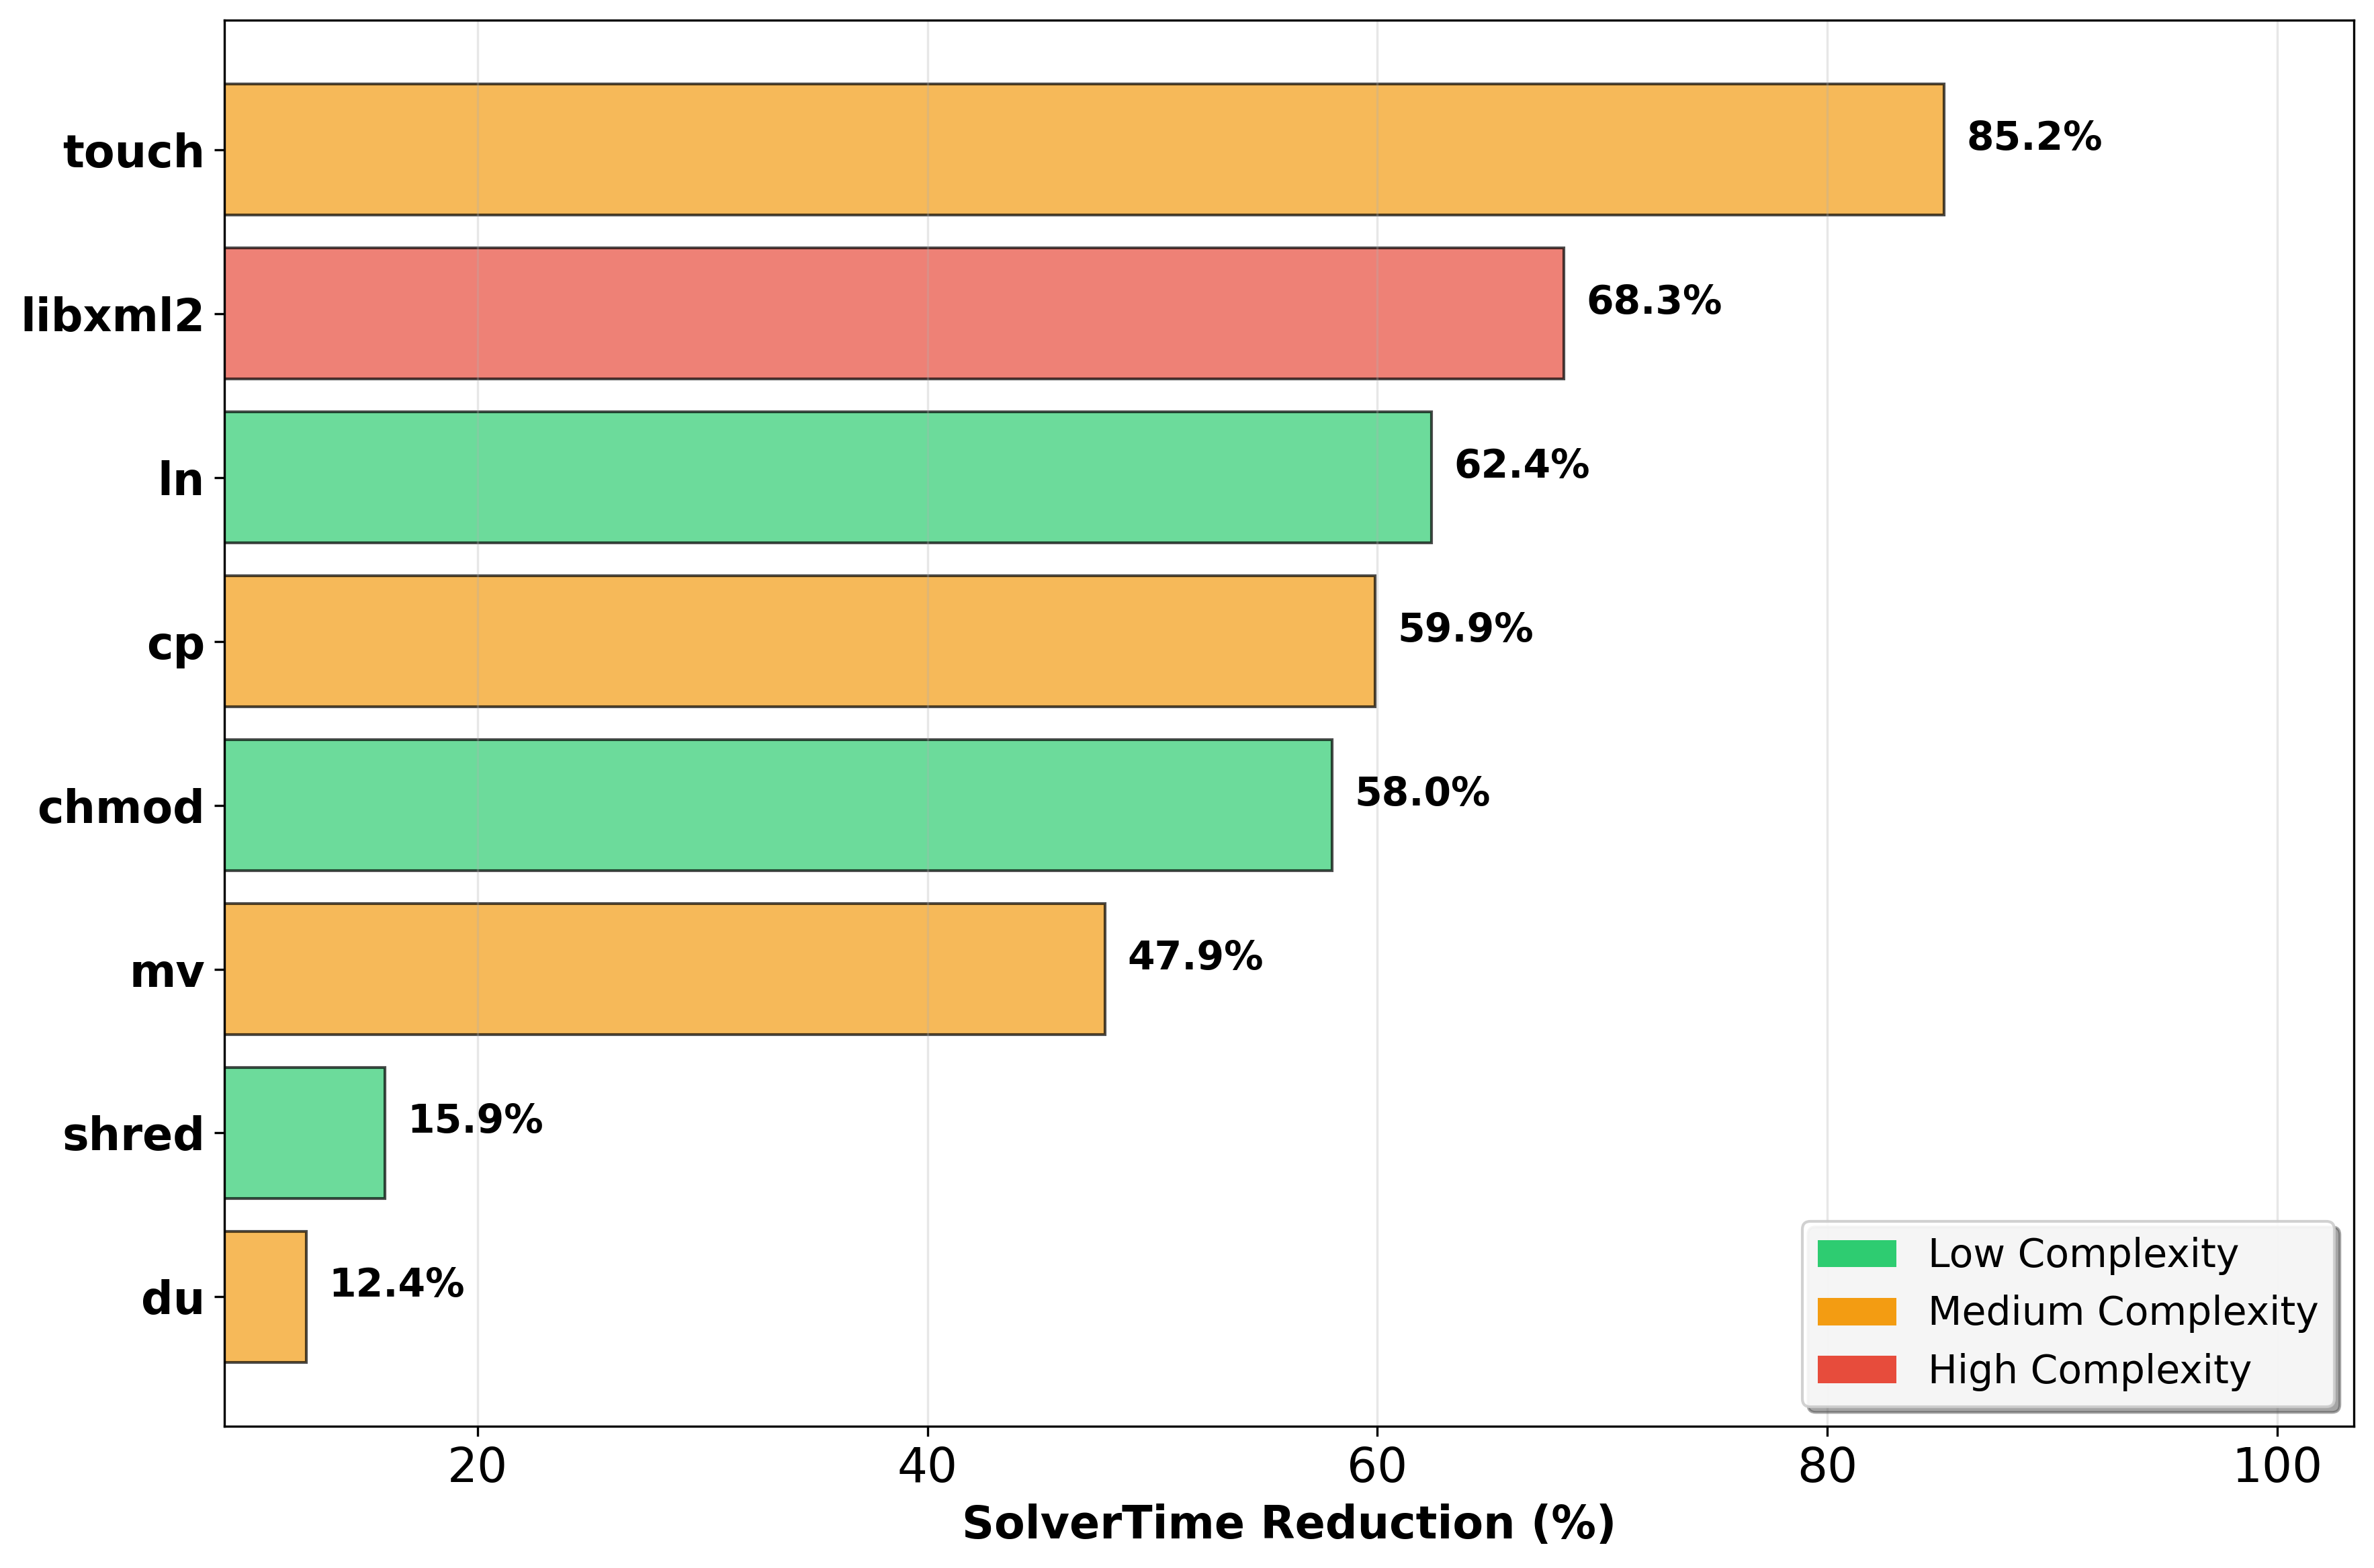

In [18]:
# Option 1: Sorted Bar Chart - Show per-program improvement
if not rq3_df.empty:
    # Sort by SolverTime Reduction for better visualization
    sorted_df = rq3_df.sort_values('SolverTime Reduction (%)', ascending=True)
    fig, ax = plt.subplots(figsize=(12, 8))
    # Create color map based on complexity
    complexity_colors = {'Low': '#2ecc71', 'Medium': '#f39c12', 'High': '#e74c3c'}
    colors = [complexity_colors[comp] for comp in sorted_df['Complexity']]
    # Create horizontal bar chart
    bars = ax.barh(range(len(sorted_df)), sorted_df['SolverTime Reduction (%)'], 
                   color=colors, alpha=0.7, edgecolor='black', linewidth=1)
    # Add value labels on bars
    for i, (idx, row) in enumerate(sorted_df.iterrows()):
        value = row['SolverTime Reduction (%)']
        ax.text(value + 1 if value >= 0 else value - 1, i,
               f'{value:.1f}%',
               fontsize=14, fontweight='bold')
    ax.set_yticks(range(len(sorted_df)))
    ax.set_yticklabels(sorted_df['Program'], fontsize=16, fontweight='bold')
    ax.set_xlabel('SolverTime Reduction (%)', fontsize=16, fontweight='bold')
    # Extend x-axis range to accommodate text labels
    x_max = sorted_df['SolverTime Reduction (%)'].max()
    x_min = sorted_df['SolverTime Reduction (%)'].min()
    x_range = x_max - x_min
    ax.set_xlim(x_min - x_range * 0.05, x_max + x_range * 0.25)  # Add 25% more space on right for labels
    ax.grid(True, alpha=0.3, axis='x')
    ax.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
    # Add legend for complexity (Patch already imported at top)
    legend_elements = [Patch(facecolor=complexity_colors['Low'], label='Low Complexity'),
                      Patch(facecolor=complexity_colors['Medium'], label='Medium Complexity'),
                      Patch(facecolor=complexity_colors['High'], label='High Complexity')]
    ax.legend(handles=legend_elements, loc='lower right', fontsize=14, frameon=True, fancybox=True, shadow=True, framealpha=0.9)
    #####ax.set_title('RQ3: SolverTime Reduction by Program (Sorted)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('rq3-bar-chart-sorted.pdf', dpi=300, bbox_inches='tight')
    plt.savefig('rq3-bar-chart-sorted.png', dpi=300, bbox_inches='tight')
    print("Option 1 saved: rq3-bar-chart-sorted.pdf and .png")
    plt.show()
else:
    print("Warning: No data available for bar chart")


## Summary

All figures have been generated and saved in the current directory:

- `rq1-parallel-coordinates-new.pdf` and `.png`
- `rq1-improvement-heatmap-new.pdf` and `.png`
- `rq2-overhead-benefit-new.pdf` and `.png`
- `rq3-performance-variation.pdf` and `.png`

**Total: 8 files (4 PDFs + 4 PNGs)**
